# Airbnb - Rio de Janeiro
* Download [data](http://insideairbnb.com/get-the-data.html)
* We downloaded `listings.csv` from all monthly dates available

## Questions
1. What was the price and supply behavior before and during the pandemic?
2. Does a title in English or Portuguese impact the price?
3. What features correlate with the price? Can we predict a price? Which features matters?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%config InlineBackend.figure_format = 'retina'

### Create dummies for categorical variables
* Remove host_id
* Transform scraping date into months and years categorical data
* Get dummies, dropping first

In [2]:
df = pd.read_pickle("treated_data.pkl")
df.head()

,id,date,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,language,appearances
0,17878,2018-04-14,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,5.598422,1.386294,5.327876,last_week,1.153732,0.000000,5.659482,en,0.0
1,24480,2018-04-14,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,5.402677,1.098612,4.454347,last_half_year,0.652325,0.000000,0.000000,en,0.0
2,25026,2018-04-14,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,5.081404,1.386294,5.342334,last_month,1.153732,1.098612,5.897154,en,0.0
3,31560,2018-04-14,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,5.402677,0.693147,5.303305,last_month,1.137833,0.000000,5.846439,en,0.0
4,35636,2018-04-14,153232,Ipanema,-22.988165,-43.193588,Entire home/apt,5.730100,0.693147,4.762174,last_month,1.141033,0.000000,4.867534,en,0.0


In [3]:
df.columns = ["Id", "Scraping Date", "Host Id", 
              "Neighbourhood", "Latitude", "Longitude", "Room Type", "Price", "Minimum Nights",
              "Number of Reviews", "Last Review", "Reviews per Month", "Calc. Host List. Count",
              "Availability 365", "Title Language", "Appearances"
             ]

In [4]:
df.dtypes

Id                                 int64
Scraping Date             datetime64[ns]
Host Id                         category
Neighbourhood                   category
Latitude                         float64
Longitude                        float64
Room Type                       category
Price                            float64
Minimum Nights                   float64
Number of Reviews                float64
Last Review                     category
Reviews per Month                float64
Calc. Host List. Count           float64
Availability 365                 float64
Title Language                  category
Appearances                      float64
dtype: object

In [5]:
df["Year"] = df["Scraping Date"].dt.year.astype("category")
df["Month"] = df["Scraping Date"].dt.month.astype("category")
df.head()

,Id,Scraping Date,Host Id,Neighbourhood,Latitude,Longitude,Room Type,Price,Minimum Nights,Number of Reviews,Last Review,Reviews per Month,Calc. Host List. Count,Availability 365,Title Language,Appearances,Year,Month
0,17878,2018-04-14,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,5.598422,1.386294,5.327876,last_week,1.153732,0.000000,5.659482,en,0.0,2018,4
1,24480,2018-04-14,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,5.402677,1.098612,4.454347,last_half_year,0.652325,0.000000,0.000000,en,0.0,2018,4
2,25026,2018-04-14,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,5.081404,1.386294,5.342334,last_month,1.153732,1.098612,5.897154,en,0.0,2018,4
3,31560,2018-04-14,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,5.402677,0.693147,5.303305,last_month,1.137833,0.000000,5.846439,en,0.0,2018,4
4,35636,2018-04-14,153232,Ipanema,-22.988165,-43.193588,Entire home/apt,5.730100,0.693147,4.762174,last_month,1.141033,0.000000,4.867534,en,0.0,2018,4


In [6]:
# Drop host_id
df = df.drop("Host Id", axis=1)

In [7]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Id,Scraping Date,Latitude,Longitude,Price,Minimum Nights,Number of Reviews,Reviews per Month,Calc. Host List. Count,Availability 365,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,17878,2018-04-14,-22.965919,-43.178962,5.598422,1.386294,5.327876,1.153732,0.000000,5.659482,...,0,1,0,0,0,0,0,0,0,0
1,24480,2018-04-14,-22.985698,-43.201935,5.402677,1.098612,4.454347,0.652325,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
2,25026,2018-04-14,-22.977117,-43.190454,5.081404,1.386294,5.342334,1.153732,1.098612,5.897154,...,0,1,0,0,0,0,0,0,0,0
3,31560,2018-04-14,-22.983024,-43.214270,5.402677,0.693147,5.303305,1.137833,0.000000,5.846439,...,0,1,0,0,0,0,0,0,0,0
4,35636,2018-04-14,-22.988165,-43.193588,5.730100,0.693147,4.762174,1.141033,0.000000,4.867534,...,0,1,0,0,0,0,0,0,0,0


In [8]:
# Create train, test sets

In [9]:
X = df.drop(["Id", "Scraping Date", "Price"], axis=1)
y = df["Price"]
X.head()

,Latitude,Longitude,Minimum Nights,Number of Reviews,Reviews per Month,Calc. Host List. Count,Availability 365,Appearances,Neighbourhood_Acari,Neighbourhood_Alto da Boa Vista,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,-22.965919,-43.178962,1.386294,5.327876,1.153732,0.000000,5.659482,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-22.985698,-43.201935,1.098612,4.454347,0.652325,0.000000,0.000000,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,-22.977117,-43.190454,1.386294,5.342334,1.153732,1.098612,5.897154,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,-22.983024,-43.214270,0.693147,5.303305,1.137833,0.000000,5.846439,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,-22.988165,-43.193588,0.693147,4.762174,1.141033,0.000000,4.867534,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Model
* I tested a Random Tree and Xgboost. Random Forest gave the best results.
* Create a Random Forest Regressor
* Split data into train and test sets, 30% being test
* We got a test RMSE of 0.26 and R2 of 0.93

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [12]:
train_pred = regressor.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = regressor.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.09935584529931986
Test RMSE: 0.2640556338742912


In [13]:
r2 = r2_score(y_test, test_pred)
adj_r2 = 1 - ((1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))

print(f"R2: {r2}, Adj. R2 {adj_r2}")

R2: 0.9302152747900228, Adj. R2 0.9301715861870992


## Model Analysis

### Feature Importance
* Geographic is the most import feature (Latitude + Longitude)
* Room Type is also very important, along with Reviews (Reviews per Month and Number of Reviews)

* It is interestring that the precise geographic coordinates are more important than the neighbourhood, that  indicate that we have different prices inside a neighbourhood (beach front aparments are more expensive than an apartment a few block away for example)

### Error Analysis
* Absolute error concetrates more in the lower price range

In [14]:
# Importance of features to determine price
importance = pd.DataFrame(regressor.feature_importances_, X_test.columns, columns=["Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
importance.iloc[:20]

,Importance
Latitude,0.186558
Longitude,0.175040
Reviews per Month,0.162478
Room Type_Private room,0.147157
Minimum Nights,0.054258
Availability 365,0.052494
Calc. Host List. Count,0.051043
Room Type_Shared room,0.042652
Appearances,0.024755
Number of Reviews,0.017722


In [15]:
# Sum importance of same categorical data
imp = {}
for row in importance.itertuples():
    cat = False
    for i in ["Neighbourhood", "Room Type", "Last Review", "Title Language", "Year", "Month"]:
        if row.Index.startswith(i):
            if i in imp.keys():
                imp[i] += row.Importance
            else:
                imp[i] = row.Importance
            cat = True
            break
    if not cat:
        imp[row.Index] = row.Importance
        
pd.DataFrame(pd.Series(imp).sort_values(ascending=False), columns=["Importance"])

,Importance
Room Type,0.191115
Latitude,0.186558
Longitude,0.175040
Reviews per Month,0.162478
Minimum Nights,0.054258
Availability 365,0.052494
Calc. Host List. Count,0.051043
Neighbourhood,0.044206
Appearances,0.024755
Number of Reviews,0.017722


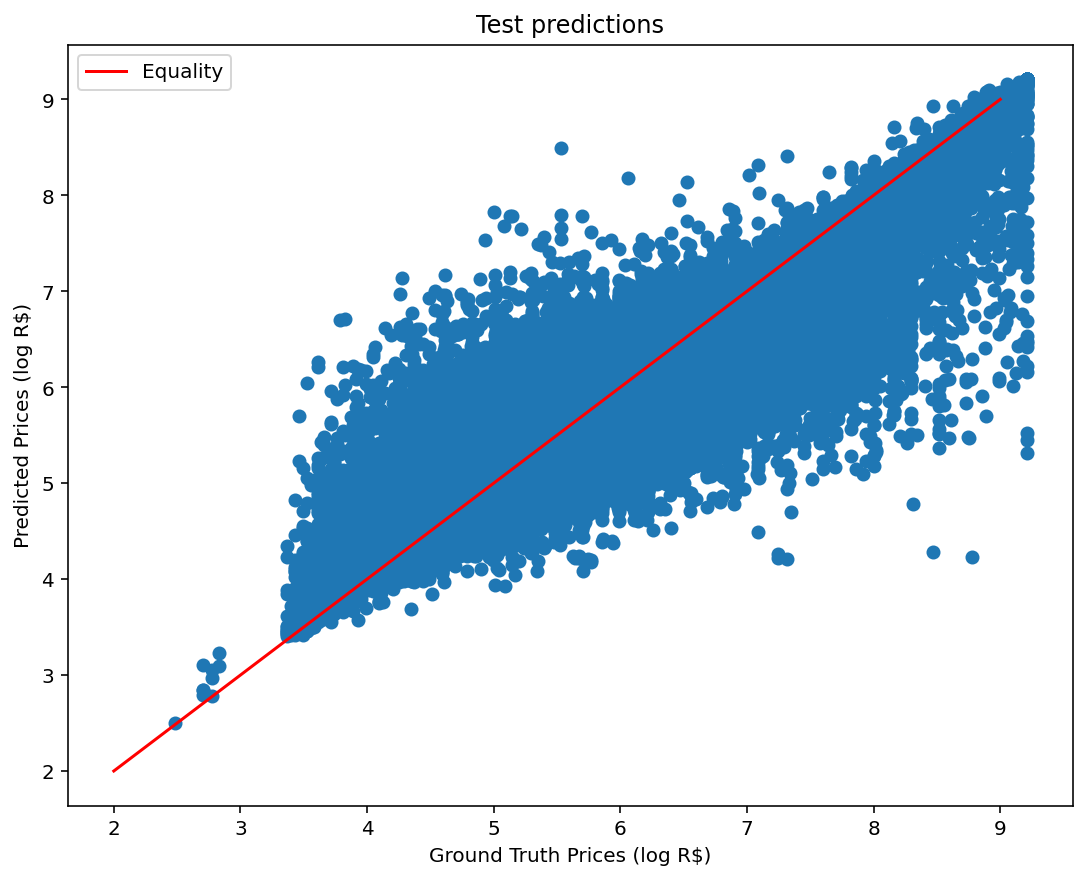

In [16]:
# Predicted prices x ground truth prices
plt.figure(figsize=(9, 7))

plt.scatter(y_test, test_pred)
plt.plot([2, 9], [2, 9], color="red", label="Equality")
plt.title("Test predictions")
plt.ylabel("Predicted Prices (log R$)")
plt.xlabel("Ground Truth Prices (log R$)")
plt.legend()
plt.show()

In [17]:
preds = pd.DataFrame()
preds["Ground Truth Prices (R$)"] = np.exp(y_test)
preds["Predicted Prices (R$)"] = np.exp(test_pred)
preds = preds.sort_values(by="Ground Truth Prices (R$)")
preds["Absolute Price Error (%)"] = np.abs(preds["Predicted Prices (R$)"] - preds["Ground Truth Prices (R$)"]) * 100 / preds["Ground Truth Prices (R$)"]
preds = preds.reset_index(drop=True)
preds.head()

,Ground Truth Prices (R$),Predicted Prices (R$),Absolute Price Error (%)
0,12.0,12.210695,1.755794
1,15.0,17.218832,14.792211
2,15.0,22.219366,48.129105
3,15.0,16.273686,8.491240
4,15.0,17.124858,14.165718


In [18]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

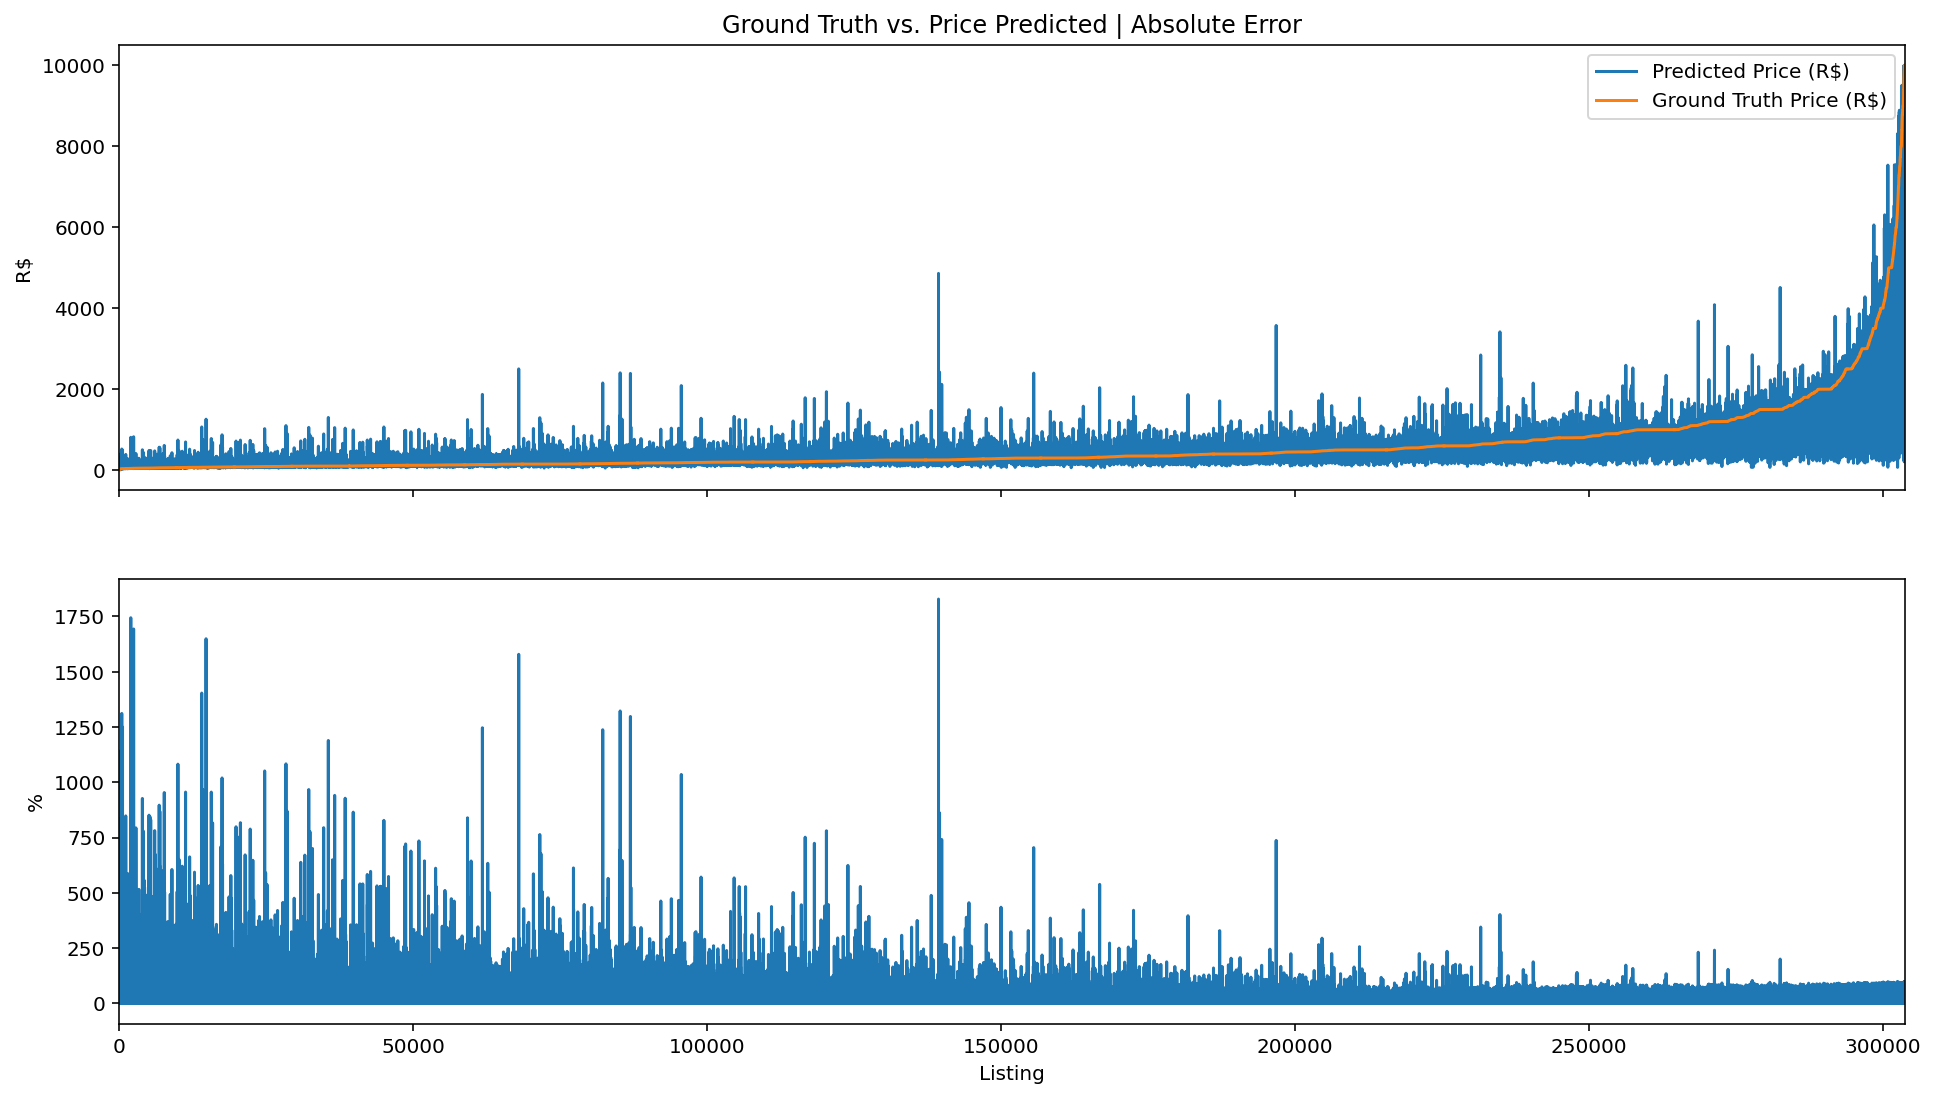

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,9))

preds["Predicted Prices (R$)"].plot(ax=axes[0], label="Predicted Price (R$)", ylabel="R$")
preds["Ground Truth Prices (R$)"].plot(ax=axes[0], label="Ground Truth Price (R$)")
preds["Absolute Price Error (%)"].plot(ax=axes[1], label="Absolute Error (%)", ylabel="%")

axes[0].set_title("Ground Truth vs. Price Predicted | Absolute Error")
axes[0].legend()

plt.xlim(0, len(preds["Ground Truth Prices (R$)"]))
plt.xlabel("Listing")

plt.show()

In [20]:
preds_log = pd.DataFrame()
preds_log["Ground Truth Prices (log R$)"] = y_test
preds_log["Predicted Prices (log R$)"] = test_pred
preds_log = preds_log.sort_values(by="Ground Truth Prices (log R$)")
preds_log["Absolute Price Error (%)"] = np.abs(preds_log["Predicted Prices (log R$)"] - preds_log["Ground Truth Prices (log R$)"]) * 100 / preds_log["Ground Truth Prices (log R$)"]
preds_log = preds_log.reset_index(drop=True)
preds_log.head()

,Ground Truth Prices (log R$),Predicted Prices (log R$),Absolute Price Error (%)
0,2.484907,2.502312,0.700452
1,2.708050,2.846004,5.094198
2,2.708050,3.100964,14.509112
3,2.708050,2.789549,3.009518
4,2.708050,2.840531,4.892113


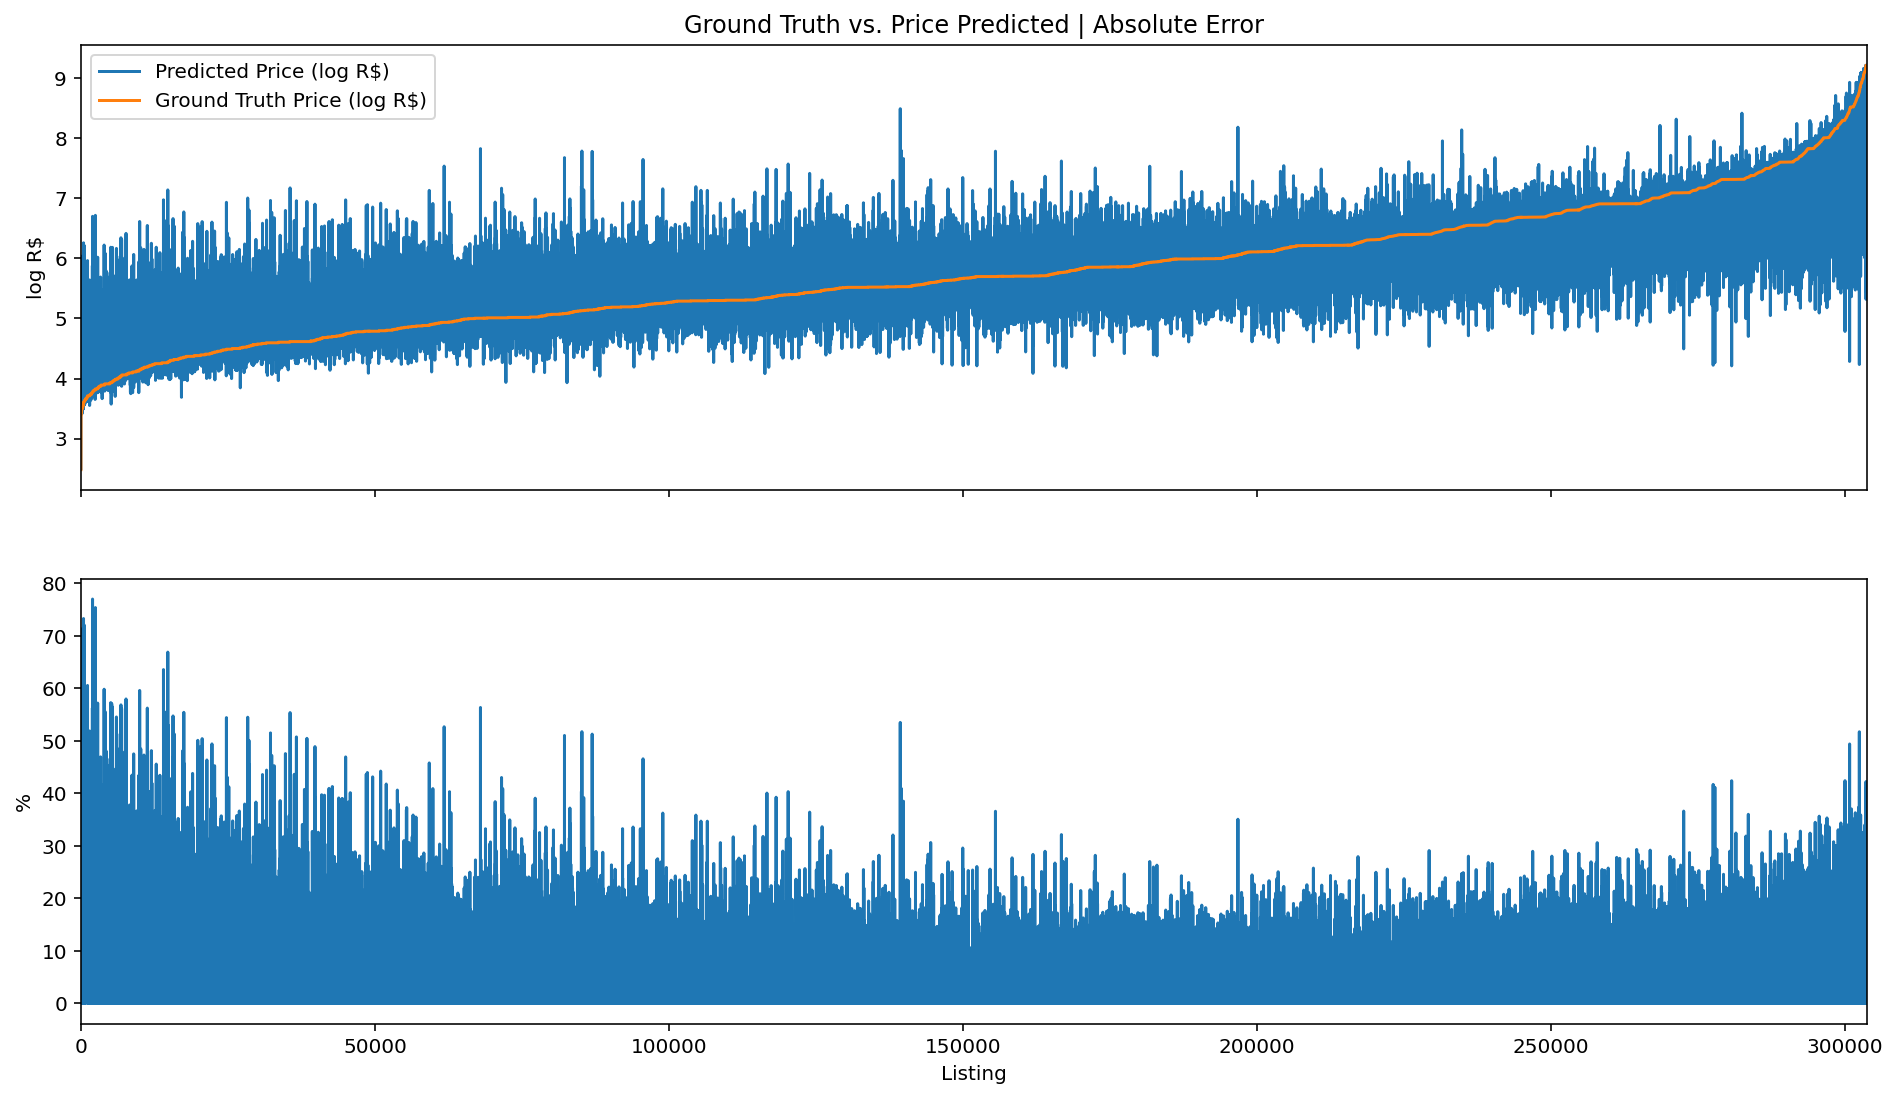

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,9))

preds_log["Predicted Prices (log R$)"].plot(ax=axes[0], label="Predicted Price (log R$)", ylabel="log R$")
preds_log["Ground Truth Prices (log R$)"].plot(ax=axes[0], label="Ground Truth Price (log R$)")
preds_log["Absolute Price Error (%)"].plot(ax=axes[1], label="Absolute Error (%)", ylabel="%")

axes[0].set_title("Ground Truth vs. Price Predicted | Absolute Error")
axes[0].legend()

plt.xlim(0, len(preds_log["Ground Truth Prices (log R$)"]))
plt.xlabel("Listing")

plt.show()